In [41]:
import numpy
import scipy.interpolate
import pandas
import matplotlib
import matplotlib.pyplot as pyplot
import pyvista
#from postProcessing import get_vtk_unstructuredgrid

In [42]:
mesh = pyvista.read('/home/asa/Desktop/SIR/poster/vtk/64_1200.vtk')
mesh.cell_data['0.3/U'] = mesh.cell_data['U']
mesh

UnstructuredGrid (0x7f85ae84abe0)
  N Cells:	890400
  N Points:	677327
  X Bounds:	-2.270e-03, 2.270e-03
  Y Bounds:	-2.270e-03, 2.270e-03
  Z Bounds:	0.000e+00, 2.000e-01
  N Arrays:	6

In [43]:
pyvista.set_jupyter_backend("ipyvtklink")
pandas.set_option("display.float_format", lambda x: f"{x:.3e}")
numpy.set_printoptions(precision=15)

In [44]:
def analytical_soln(r, rp, mu, uavg):
    """Analytical solution to pipe flow.
    
    Arguments
    ---------
    r : float or array-like
        The distance(s) from a point or points to the pipe's center.
    rp : float
        The radius of the target pipe.
    mu : float
        The dynamic viscosity, or the kinematic viscosity if the density is 1.
    uavg : float
        The average flow velocity, or the inlet velocity if it is uniform.
    
    Returns
    -------
    The along-pipe velocity at the point(s).
    """
    rp2 = rp * rp
    return 2 * uavg * (rp2 - r * r) / rp2

In [45]:
# constants
# ---------
lpipe = 0.12  # m
rpipe = 2.27e-3  # m
mu = 1.48e-5  # m^2 / s
uavg = 0.521646  # m / s

# analysis configurations
# -----------------------
nslcs = 16  # number of slices to inspect

# get a pyvista.UnstructuredGrid
# ------------------------------
case = mesh

In [46]:
 case.extract_all_edges().compute_cell_sizes()["Length"].min() / 2.

2.5030034085423245e-05

In [47]:
# get slices along pipe
# ---------------------

# cross-sections' locations
locs = numpy.linspace(0., lpipe, nslcs+2)[2:]  # we don't want slices close to the entry

# bounds in xy
xybound = [-rpipe*1.1, rpipe*1.1, -rpipe*1.1, rpipe*1.1]

# rounding error tolerance becasue VTK has many algorithms are still using 32bit float
tol = case.extract_all_edges().compute_cell_sizes()["Length"].min() / 2.

# get "volumetric" slices
slcs = []
for loc in locs:
    ids = case.find_cells_within_bounds(xybound+[loc+tol, loc+tol])
    if len(ids) == 0:  # apply the tolerance to try again
        ids = case.find_cells_within_bounds(xybound+[loc-2*tol, loc-2*tol])
    slcs.append(case.extract_cells(ids))

# use pandas to host the cross-sectional grids
slcs = pandas.Series(
    data=[
        mesh.slice(normal="z", origin=mesh.center).compute_cell_sizes()  # get surface slices w/ areas
        for mesh in slcs
    ],
    index=pandas.Index(map(lambda x: f"{x:.3f}", locs), name="z (m)", dtype=str),
    dtype=object,
    name="Slice Mesh"
)

In [48]:
# get cross-sectional errors (against analytical soln)
# ----------------------------------------------------
for sec, slc in slcs.items():
    centers = slc.cell_centers(False).points[:, :2]
    r = numpy.linalg.norm(centers, axis=1)
    soln = analytical_soln(r, rpipe, mu, uavg)
    for key, val in slc.cell_data.items():
        if "/U" not in key:
            continue
        time = key.replace("/U", "")
        slc.cell_data[time+"/err"] = numpy.abs(val[:, 2]-soln)        

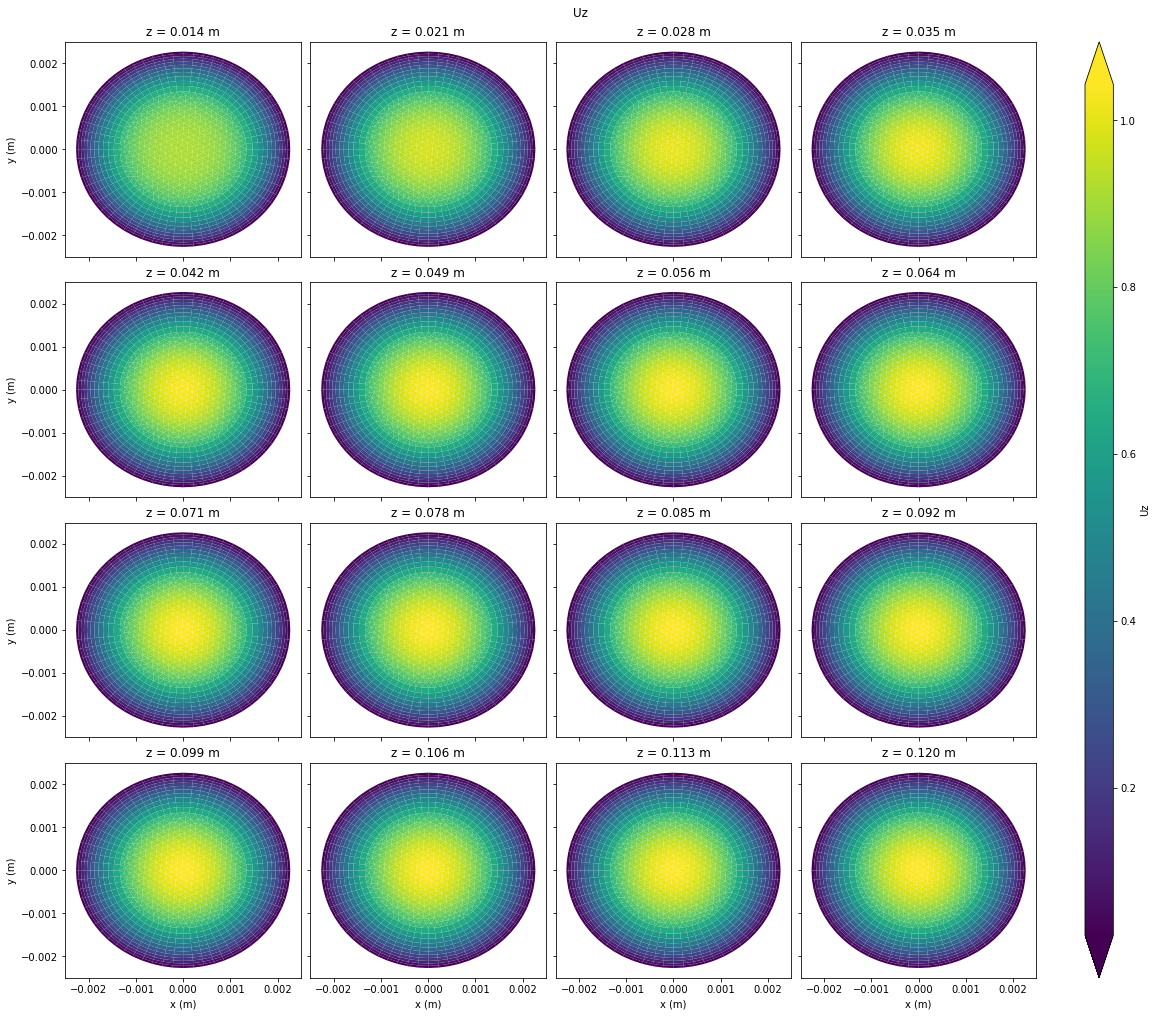

In [49]:
# soln visualization
# -------------------

# number of subplots
ncols = 4
nrows = nslcs // ncols + int(nslcs % ncols != 0)

# target time (in str)
time = "0.3" 

# unify colorbar and color range
mapper = matplotlib.cm.ScalarMappable(
    matplotlib.colors.Normalize(
        vmin=min(map(lambda slc: slc[f"{time}/U"][:, 2].min(), slcs)),
        vmax=max(map(lambda slc: slc[f"{time}/U"][:, 2].max(), slcs))
    ),
    cmap="viridis"
)

fig, axs = pyplot.subplots(
    nrows, ncols, sharex=True, sharey=True, figsize=(16, 14),
    constrained_layout=True
)

for i, (key, slc) in enumerate(slcs.items()):
    centers = slc.cell_centers(False).points[:, :2]
    r = numpy.linalg.norm(centers, axis=1)
    soln = analytical_soln(r, rpipe, mu, uavg)
    
    #get coordinates of cell vertices
    abc =[]
    idx = 0
    for j in range(slc.n_faces):
        
        bg = idx+1
        end = idx+slc.faces[idx]
        # add numbers of cell vertices 
        abc.append(list(slc.faces[bg:end+1]))
        idx +=(slc.faces[idx]+1)
        
    coord = []
    for face in abc:
        coord.append([])
        for k in face:
            coord[-1].append(slc.points[k,:2])
            
    polys = matplotlib.collections.PolyCollection(
        coord,
        facecolors=mapper.to_rgba(slc.cell_data[f"{time}/U"][:, 2])
    )
    #polys.set_array(slc.cell_data["1/U"][:, 2])
    ax = axs[i//ncols, i%ncols]
    ax.add_collection(polys)
    ax.set_title(f"z = {key} m")
    ax.autoscale_view()

for i in range(ncols):
    axs[nrows-1, i].set_xlabel("x (m)")
    
for i in range(nrows):
    axs[i, 0].set_ylabel("y (m)")

fig.colorbar(mapper, ax=axs, extend="both", aspect=30, label="Uz")
fig.suptitle("Uz");

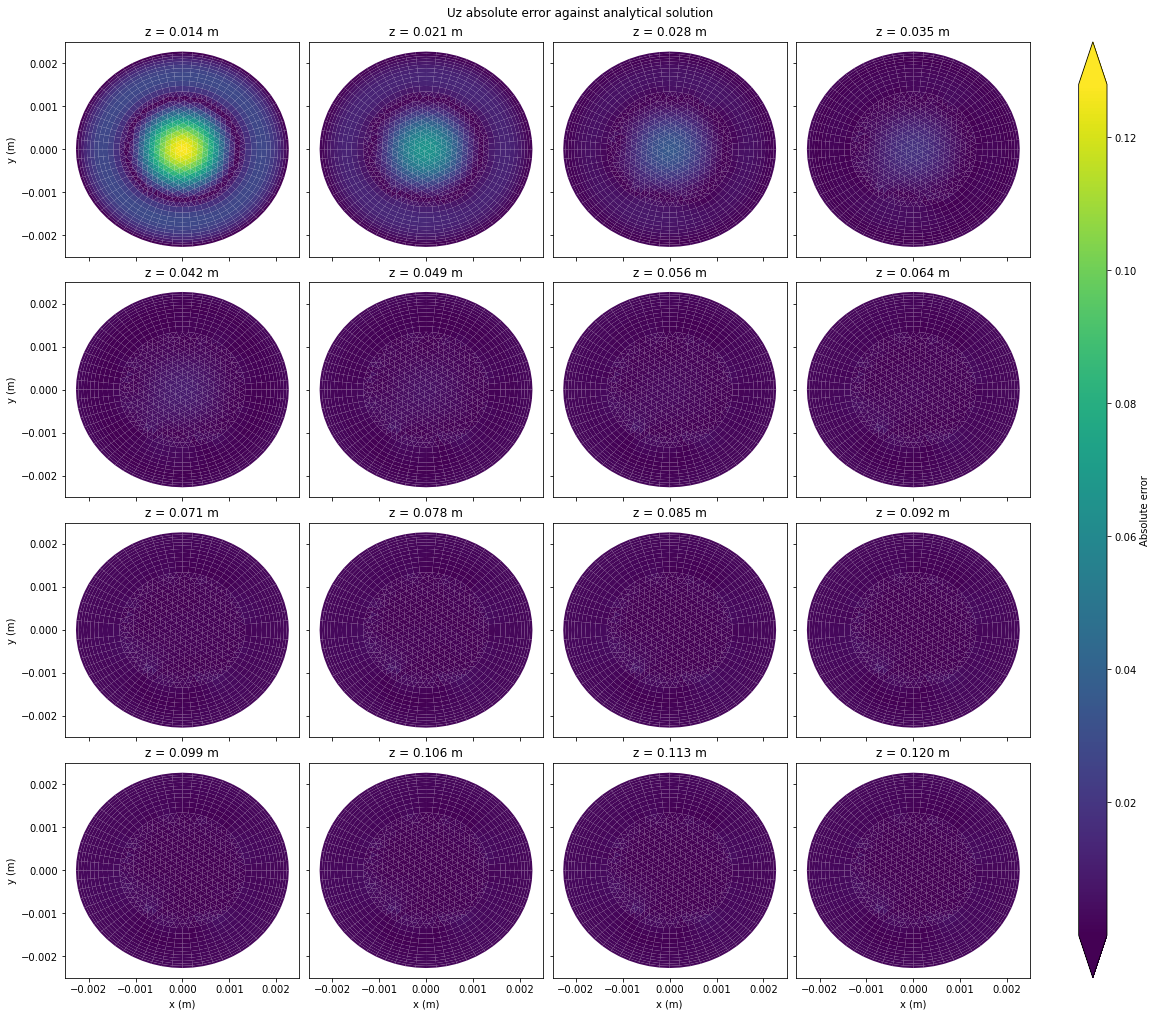

In [50]:
# error visualization
# -------------------

# number of subplots
ncols = 4
nrows = nslcs // ncols + int(nslcs % ncols != 0)

# target time (in str)
time = "0.3"  # 1 second

# unify colorbar and color range
mapper = matplotlib.cm.ScalarMappable(
    matplotlib.colors.Normalize(
        vmin=min(map(lambda slc: slc[f"{time}/err"].min(), slcs)),
        vmax=max(map(lambda slc: slc[f"{time}/err"].max(), slcs))
    ),
    cmap="viridis"
)

fig, axs = pyplot.subplots(
    nrows, ncols, sharex=True, sharey=True, figsize=(16, 14),
    constrained_layout=True
)

for i, (key, slc) in enumerate(slcs.items()):
    abc =[] # n
    idx = 0
    for j in range(slc.n_faces):
        bg = idx+1
        end = idx+slc.faces[idx]
        abc.append(list(slc.faces[bg:end+1]))
        idx +=(slc.faces[idx]+1)
        
        
    coord = []
    for face in abc:
        coord.append([])
        for k in face:
            coord[-1].append(slc.points[k,:2])
            
    polys = matplotlib.collections.PolyCollection(
        coord,
        facecolors=mapper.to_rgba(slc.cell_data["0.3/err"])
    )
    #print(len(coord))
    
    ax = axs[i//ncols, i%ncols]
    ax.add_collection(polys)
    ax.set_title(f"z = {key} m")
    ax.autoscale_view()

for i in range(ncols):
    axs[nrows-1, i].set_xlabel("x (m)")
    
for i in range(nrows):
    axs[i, 0].set_ylabel("y (m)")

fig.colorbar(mapper, ax=axs, extend="both", aspect=30, label="Absolute error")
#fig.savefig('64.png',dpi =900)
fig.suptitle("Uz absolute error against analytical solution");

In [51]:
# table of L2-norms
# ------------------
table = pandas.DataFrame(
    index=slcs.index,
    columns=pandas.Index(
        [col.replace("/U", "") for col in case.cell_data.keys() if "/U" in col],
        name="time (s)", dtype=str),
    dtype=float
)
table = table.sort_index(axis=1, key=lambda x: x.astype(float))

for key, slc in slcs.items():
    for col in table.columns:
        table.loc[key, col] = numpy.sqrt(numpy.sum(slc["Area"]*slc[col+"/err"]**2))
        
print("L2-norm of cross-sectional z-velocity")
display(table)

L2-norm of cross-sectional z-velocity


time (s),0.3
z (m),
0.014,1.515e-04
0.021,7.614e-05
0.028,3.936e-05
0.035,2.088e-05
0.042,1.184e-05
0.049,8.660e-06
0.056,7.940e-06
0.064,7.955e-06
0.071,8.085e-06


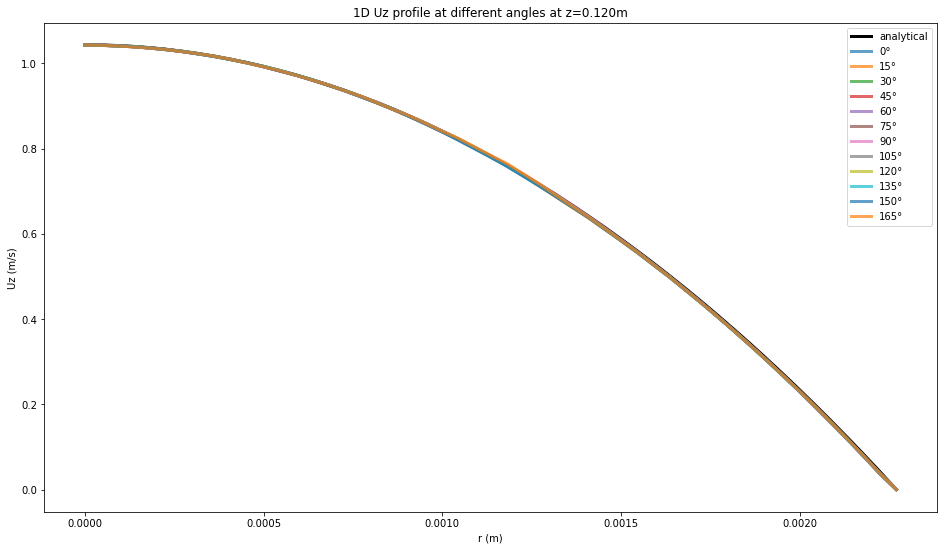

In [52]:
# line profile at the last cross section
# ---------------------------------------
xy = slcs[-1].cell_centers().points[:, :2]

# interpolator
#interpolator = scipy.interpolate.SmoothBivariateSpline(xy[:, 0], xy[:, 1], slcs[-1]["1/U"][:, 2])
interpolator = scipy.interpolate.LinearNDInterpolator(xy, slcs[-1][f"{time}/U"][:, 2], 0.)

# baseline at horizontal
baseline = numpy.concatenate((
    numpy.linspace(0, rpipe, 51)[:, None],
    numpy.zeros(51)[:, None]
), axis=1)

# different angles to plot 1D profile
thetas = numpy.linspace(0., 180., 12, endpoint=False) / 180. * numpy.pi

# analytical solutions
soln = analytical_soln(baseline[:, 0], rpipe, mu, uavg)

# initialize figure
pyplot.figure(figsize=(16, 9))

# plot the analytical solution
pyplot.plot(baseline[:, 0], soln, color="k", lw=3, label="analytical")

# plot interpolated simulation results
for theta in thetas:
    # rotate the baseline
    line = numpy.array(
        [
            [numpy.cos(theta), -numpy.sin(theta)],
            [numpy.sin(theta), numpy.cos(theta)]
        ],
        dtype=numpy.float64
    ).dot(baseline.T).T
    
    # interpolation
    vals = interpolator(line[:, 0], line[:, 1])  #, grid=False)
    
    # plot
    pyplot.plot(
        baseline[:, 0], vals, lw=3, alpha=0.7,
        label=f"{int(theta*180/numpy.pi+0.5)}" + u"\u00B0"
    )
pyplot.xlabel("r (m)")
pyplot.ylabel("Uz (m/s)")
pyplot.title(f"1D Uz profile at different angles at z={slcs.index[-1]}m")
pyplot.legend();